In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import binned_statistic_2d
# from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.cm as cm

# from abacusnbody.analysis.tsc import tsc_parallel
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Import packages

sys.path.append('../src/')
# from filter_utils import *
from SZstacker import SZMapStacker # type: ignore
from stacker import SimulationStacker

# sys.path.append('../../illustrisPython/')
import illustris_python as il # type: ignore

import yaml
import argparse
from pathlib import Path


In [2]:
np.isclose(1.1, 1.10000000001)

True

In [2]:
path2config = '../scripts/configs/tau_z05_CAP.yaml'

In [3]:
with open(path2config) as f:
    config = yaml.safe_load(f)

redshift = config['redshift']
filterType = config['filter_type']
plotErrorBars = config['plot_error_bars']
loadField = config['load_field']
saveField = config['save_field']
radDistance = config['rad_distance']
pType = config['particle_type']

# fractionType = config['fraction_type']

figPath = Path(config['fig_path'])
figPath.mkdir(parents=False, exist_ok=True)

figName = config['fig_name']
figType = config['fig_type']

colourmaps = ['hot', 'cool']
verbose = False

/pscratch/sd/r/rhliu/simulations/IllustrisTNG/TNG100-3/output//snapdir_067/snap_067.0.hdf5


OSError: Unable to synchronously open file (truncated file: eof = 2966801296, sblock->base_addr = 0, stored_eof = 4171526684)

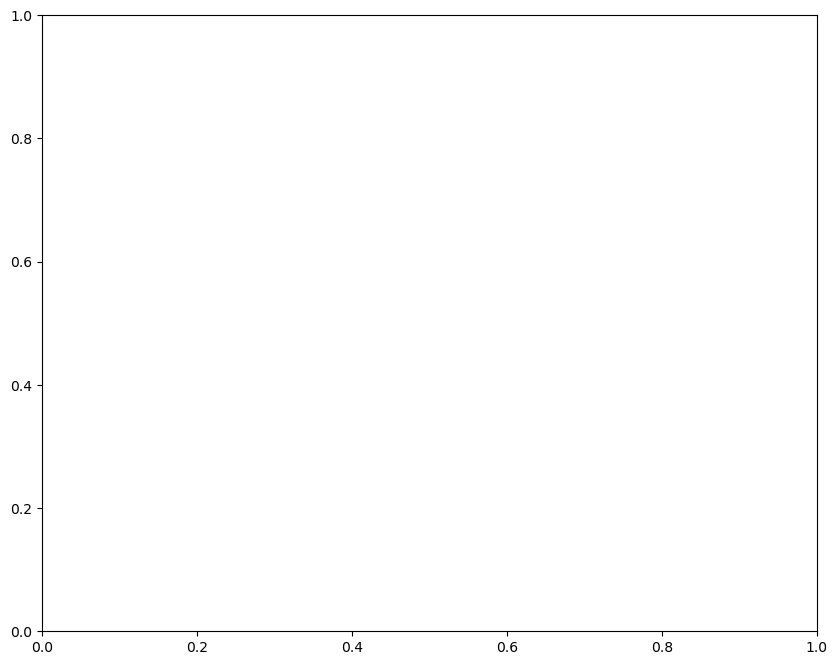

In [4]:
fig, ax = plt.subplots(figsize=(10,8))
t0 = time.time()
for i, sim_type in enumerate(config['simulations']):
    sim_type_name = sim_type['sim_type']
    
    colourmap = matplotlib.colormaps[colourmaps[i]] # type: ignore
    
    if sim_type_name == 'IllustrisTNG':
        TNG_sims = sim_type['sims']
        colours = colourmap(np.linspace(0.2, 0.85, len(TNG_sims)))
    if sim_type_name == 'SIMBA':
        SIMBA_sims = sim_type['sims']
        colours = colourmap(np.linspace(0.2, 0.85, len(SIMBA_sims)))

    if verbose:
        print(f"Processing simulations of type: {sim_type_name}")
    
    for j, sim in enumerate(sim_type['sims']):
        sim_name = sim['name']
        snapshot = sim['snapshot']
        
        if verbose:
            print(f"Processing simulation: {sim_name}")
        
        if sim_type_name == 'IllustrisTNG':
            
            stacker = SZMapStacker(sim_name, snapshot, z=redshift, 
                                    simType=sim_type_name)
            
            radii0, profiles0 = stacker.stackMap(pType, filterType=filterType, maxRadius=6.0, # type: ignore
                                                    save=saveField, load=loadField, radDistance=radDistance)


            try:
                OmegaBaryon = stacker.header['OmegaBaryon']
            except KeyError:
                OmegaBaryon = 0.0456  # Default value for Illustris-1

            

        elif sim_type_name == 'SIMBA':
            # SIMBA simulations have different feedback models               
            feedback = sim['feedback']

            sim_name_show = sim_name + '_' + feedback
            if verbose:
                print(f"Processing feedback model: {feedback}")
            
            stacker = SZMapStacker(sim_name, snapshot, z=redshift,
                                    simType=sim_type_name, 
                                    feedback=feedback)
            
            radii0, profiles0 = stacker.stackMap(pType, filterType=filterType, maxRadius=6.0,  # type: ignore
                                                    save=saveField, load=loadField, radDistance=radDistance)
                            
            OmegaBaryon = 0.048  # Default value for SIMBA

            # if fractionType == 'gas':
            #     fraction = profiles0 / (profiles0 + profiles1 + profiles4 + profiles5) / (OmegaBaryon / stacker.header['Omega0']) # OmegaBaryon = 0.048 from Planck 2015
            # elif fractionType == 'baryon':
            #     fraction = (profiles0 + profiles4 + profiles5) / (profiles0 + profiles1 + profiles4 + profiles5) / (OmegaBaryon / stacker.header['Omega0']) # OmegaBaryon = 0.048 from Planck 2015

            # fraction_plot = np.median(fraction, axis=1)
            # ax.plot(radii0 * radDistance, fraction_plot, label=sim_name_show, color=colours[j], lw=2)
            # # ax.plot(radii0 * radDistance, profiles0.mean(axis=1), label=sim_name_show, color=colours[j], lw=2)
            # # ax.plot(radii0 * radDistance, profiles0, label=sim_name_show, color=colours[j], lw=2)
            # if plotErrorBars:
            #     fraction_err = np.std(fraction, axis=1) / np.sqrt(fraction.shape[1])
            #     upper = np.percentile(fraction, 75, axis=1)
            #     lower = np.percentile(fraction, 25, axis=1)
            #     ax.fill_between(radii0 * radDistance, 
            #                     lower, 
            #                     upper, 
            #                     color=colours[j], alpha=0.2)
        else:
            raise ValueError(f"Unknown simulation type: {sim_type_name}")

        
        # Now for Plotting
        
        # if fractionType == 'gas':
        #     fraction = profiles0 / (profiles0 + profiles1 + profiles4) / (OmegaBaryon / stacker.header['Omega0']) # OmegaBaryon = 0.048 from Planck 2015
        # elif fractionType == 'baryon':
        #     fraction = (profiles0 + profiles4) / (profiles0 + profiles1 + profiles4) / (OmegaBaryon / stacker.header['Omega0']) # OmegaBaryon = 0.048 from Planck 2015
        

        profiles_plot = np.mean(profiles0, axis=1)
        ax.plot(radii0 * radDistance, profiles_plot, label=sim_name, color=colours[j], lw=2, marker='o')
        if plotErrorBars:
            profiles_err = np.std(profiles0, axis=1) / np.sqrt(profiles0.shape[1])
            upper = np.percentile(profiles0, 75, axis=1)
            lower = np.percentile(profiles0, 25, axis=1)
            ax.fill_between(radii0 * radDistance, 
                            lower, 
                            upper, 
                            color=colours[j], alpha=0.2)


# ax.set_xlabel('Radius (arcmin)')
# ax.set_ylabel('f')
ax.set_xlabel('R [arcmin]', fontsize=18)
ax.set_ylabel(r'$f_{\rm gas}(< R) / (\Omega_b/\Omega_m)$', fontsize=18)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.0, 6.5)
# ax.set_ylim(0, 1.2)
# ax.axhline(1.0, color='k', ls='--', lw=2)
ax.legend(loc='lower right', fontsize=12)
ax.grid(True)
ax.set_title(f'{filterType} filter at z={redshift}', fontsize=18)

fig.tight_layout()
# fig.savefig(figPath / f'{figName}_{pType}_z{redshift}_{filterType}.{figType}', dpi=300) # type: ignore
plt.show()
plt.close(fig)

print('Done!!!')


In [ ]:
T_CMB = 2.7255 # CMB temperature in K

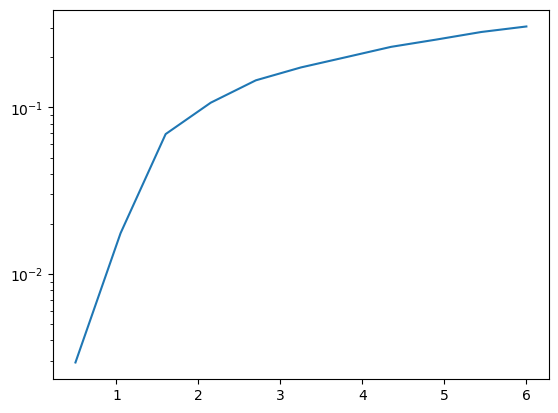

In [ ]:
profiles_result = np.mean(profiles0 * T_CMB * 1e6, axis=1) 

plt.semilogy(radii0 * radDistance, profiles_result)